# Domain-Specific User Journeys Visualization

This notebook visualizes user journeys across different domains to show more realistic shopping patterns. It builds on the analysis from the `combined_user_journeys.ipynb` notebook, but groups sessions by domain for each user.

In [32]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
from matplotlib.gridspec import GridSpec

# Load the same dataset as in the original notebooks
df = pd.read_csv('analytics.csv')

# Set the same colors as in the original notebook for consistency
colors = ['salmon', '#F899F3', '#73FABD', '#6ED1F8','#E0F26D', '#106ED3']
facecolor = '#F5F5F5'

# Create a custom colormap for user differentiation
user_colors = plt.cm.tab10.colors  # This gives us 10 distinct colors for different users

# Create a custom colormap for domain differentiation
domain_colors = plt.cm.Set2.colors  # This gives us 8 distinct colors for different domains

In [33]:
# Clean the data and filter relevant entries
# Remove entries without user_id or with placeholder user_ids
df_filtered = df[(df['user_id'] != 'none') & (df['user_id'] != 'less-website')].copy()

# Convert timestamp strings to datetime objects
df_filtered['timestamp'] = pd.to_datetime(df_filtered['created_at'], format='ISO8601')

# Define purchase event indicators
purchase_event_types = ['enforce_wait_modal_shown']

# Function to check if an event type indicates a purchase
def is_purchase_event(event_type):
    # Check for exact matches
    if event_type in purchase_event_types:
        return True
    
    # Check for partial matches in case the naming convention varies
    for purchase_type in purchase_event_types:
        if purchase_type.lower() in event_type.lower():
            return True
    
    return False

# Add a column to identify purchase events
df_filtered['is_purchase'] = df_filtered['type'].apply(is_purchase_event)

# Define the other event types we're interested in
df_filtered['is_add_to_cart'] = df_filtered['type'] == 'add-to-cart'
df_filtered['is_checkout'] = df_filtered['type'] == 'checkout'

In [34]:
# Process sessions similar to the original notebook, but also track the domain
session_groups = df_filtered.groupby('session_id')

# Extract session start times, end times, duration, domain, and whether each session contains a purchase
session_data = []
for session_id, session_df in session_groups:
    # Skip sessions with invalid or placeholder IDs
    if session_id == 'none' or pd.isna(session_id):
        continue
        
    # Sort session events by timestamp
    session_df = session_df.sort_values('timestamp')
    
    # Get user_id (assuming it's consistent within a session)
    user_id = session_df['user_id'].iloc[0] if not session_df.empty else None
    
    # Get the domain for this session (use the most common domain in the session)
    domain = session_df['domain'].mode().iloc[0] if not session_df.empty and 'domain' in session_df.columns else 'unknown'
    
    # Get session start and end times
    start_time = session_df['timestamp'].min()
    end_time = session_df['timestamp'].max()
    
    # Calculate session duration in minutes
    duration_minutes = (end_time - start_time).total_seconds() / 60
    
    # Check for each event type - ensuring uniqueness per session by using .any()
    has_add_to_cart = session_df['is_add_to_cart'].any()
    has_checkout = session_df['is_checkout'].any()
    has_purchase = session_df['is_purchase'].any()
    
    # Find timestamps for FIRST occurrence of each event type
    add_to_cart_time = session_df[session_df['is_add_to_cart']]['timestamp'].min() if has_add_to_cart else None
    checkout_time = session_df[session_df['is_checkout']]['timestamp'].min() if has_checkout else None
    purchase_time = session_df[session_df['is_purchase']]['timestamp'].min() if has_purchase else None
    
    # Determine event sequence order based on first occurrences
    event_order = []
    if has_add_to_cart:
        event_order.append(('add_to_cart', add_to_cart_time))
    if has_checkout:
        event_order.append(('checkout', checkout_time))
    if has_purchase:
        event_order.append(('purchase', purchase_time))
    
    # Sort events by timestamp
    event_order.sort(key=lambda x: x[1])
    
    # Extract the ordered sequence of event types
    event_sequence = [event[0] for event in event_order]
    event_sequence_str = ' → '.join(event_sequence) if event_sequence else 'no_events'
    
    # Collect relevant session details
    session_data.append({
        'session_id': session_id,
        'user_id': user_id,
        'domain': domain,
        'start_time': start_time,
        'end_time': end_time,
        'duration_minutes': duration_minutes,
        'has_add_to_cart': has_add_to_cart,
        'has_checkout': has_checkout,
        'has_purchase': has_purchase,
        'event_sequence': event_sequence_str,
        'event_count': len(session_df)
    })

# Create DataFrame from collected session data
sessions_df = pd.DataFrame(session_data)

# Add flow categorization
def categorize_flow(row):
    # Complete flow
    if row['has_add_to_cart'] and row['has_checkout'] and row['has_purchase']:
        return 'Complete Flow'
    
    # Add to cart then checkout
    elif row['has_add_to_cart'] and row['has_checkout'] and not row['has_purchase']:
        return 'Add-to-Cart then Checkout'
    
    # Checkout then purchase
    elif not row['has_add_to_cart'] and row['has_checkout'] and row['has_purchase']:
        return 'Checkout then Purchase'
    
    # Just add to cart
    elif row['has_add_to_cart'] and not row['has_checkout'] and not row['has_purchase']:
        return 'Add-to-Cart'
    
    # Just checkout
    elif not row['has_add_to_cart'] and row['has_checkout'] and not row['has_purchase']:
        return 'Checkout'
    
    # Just purchase (unusual but possible)
    elif not row['has_add_to_cart'] and not row['has_checkout'] and row['has_purchase']:
        return 'Direct Purchase'
    
    # Just looking
    else:
        return 'Just Looking'

# Apply the flow categorization
sessions_df['flow_category'] = sessions_df.apply(categorize_flow, axis=1)

# Add the simpler categorization as well
def categorize_session(row):
    if not row['has_purchase']:
        return 'Just Looking'
    elif row['duration_minutes'] >= 20:
        return 'Looking Then Purchasing'
    else:
        return 'Quick Purchase'

sessions_df['category'] = sessions_df.apply(categorize_session, axis=1)

# Show basic statistics
print(f"Total sessions: {len(sessions_df)}")
print(f"Sessions with purchases: {sessions_df['has_purchase'].sum()}")
print(f"Unique users: {sessions_df['user_id'].nunique()}")
users_with_purchases = sessions_df[sessions_df['has_purchase']]['user_id'].nunique()
print(f"Users with at least one purchase: {users_with_purchases}")
print(f"Percentage of users who made purchases: {users_with_purchases / sessions_df['user_id'].nunique() * 100:.2f}%")
print(f"Unique domains: {sessions_df['domain'].nunique()}")

Total sessions: 137
Sessions with purchases: 10
Unique users: 36
Users with at least one purchase: 7
Percentage of users who made purchases: 19.44%
Unique domains: 34


In [35]:
# Identify users who made at least one purchase
purchasing_users = sessions_df[sessions_df['has_purchase']]['user_id'].unique()
print(f"Number of users who made at least one purchase: {len(purchasing_users)}")

# For each purchasing user, get all their sessions and sort by time
purchasing_user_sessions = sessions_df[sessions_df['user_id'].isin(purchasing_users)].copy()

# For each user, find their first purchase session
first_purchase_sessions = []
journey_to_purchase_data = []

for user_id in purchasing_users:
    # Get all sessions for this user
    user_sessions = purchasing_user_sessions[purchasing_user_sessions['user_id'] == user_id].sort_values('start_time')
    
    # Find the first purchase session for this user
    first_purchase_idx = user_sessions['has_purchase'].idxmax() if user_sessions['has_purchase'].any() else None
    
    if first_purchase_idx is not None:
        first_purchase_session = user_sessions.loc[first_purchase_idx]
        first_purchase_sessions.append(first_purchase_session)
        
        # Get all sessions before the first purchase
        pre_purchase_sessions = user_sessions[user_sessions['start_time'] < first_purchase_session['start_time']]
        
        # Get unique domains visited before purchase
        domains_visited = pre_purchase_sessions['domain'].unique().tolist() if not pre_purchase_sessions.empty else []
        
        # Add journey information
        journey_to_purchase_data.append({
            'user_id': user_id,
            'total_sessions_before_purchase': len(pre_purchase_sessions),
            'days_to_first_purchase': (first_purchase_session['start_time'] - user_sessions['start_time'].min()).total_seconds() / (60*60*24) if len(user_sessions) > 1 else 0,
            'first_purchase_session_id': first_purchase_session['session_id'],
            'first_purchase_category': first_purchase_session['category'],
            'first_purchase_flow': first_purchase_session['flow_category'],
            'pre_purchase_session_categories': pre_purchase_sessions['category'].tolist() if not pre_purchase_sessions.empty else [],
            'pre_purchase_flow_categories': pre_purchase_sessions['flow_category'].tolist() if not pre_purchase_sessions.empty else [],
            'domains_visited': domains_visited,
            'unique_domains_count': len(domains_visited),
            'pre_purchase_just_looking_count': sum(1 for cat in pre_purchase_sessions['category'] if cat == 'Just Looking'),
            'pre_purchase_add_to_cart_count': sum(1 for flow in pre_purchase_sessions['flow_category'] if 'Add-to-Cart' in flow),
            'pre_purchase_checkout_count': sum(1 for flow in pre_purchase_sessions['flow_category'] if 'Checkout' in flow)
        })

# Create DataFrame for journey analysis
journey_df = pd.DataFrame(journey_to_purchase_data)

# Show some statistics
print(f"Number of users with journey data: {len(journey_df)}")
print(f"Average sessions before first purchase: {journey_df['total_sessions_before_purchase'].mean():.2f}")
print(f"Average unique domains visited: {journey_df['unique_domains_count'].mean():.2f}")
print(f"Average days to first purchase: {journey_df['days_to_first_purchase'].mean():.2f}")

Number of users who made at least one purchase: 7
Number of users with journey data: 7
Average sessions before first purchase: 1.14
Average unique domains visited: 0.86
Average days to first purchase: 1.88


## Select Users for Domain-Specific Journey Visualization

Let's select users who visited multiple domains before making a purchase, to demonstrate cross-domain shopping patterns.

In [36]:
# Find users who visited multiple domains
multi_domain_users = journey_df[journey_df['unique_domains_count'] >= 2].sort_values(
    by='unique_domains_count', ascending=False)
print(f"Users who visited multiple domains: {len(multi_domain_users)}")

# Select the top users with most domains visited
selected_users = multi_domain_users.head(6)['user_id'].tolist()
if len(selected_users) < 6 and len(journey_df) >= 6:
    # Add more users to make up 6 if needed
    additional_users = journey_df[~journey_df['user_id'].isin(selected_users)].head(6 - len(selected_users))['user_id'].tolist()
    selected_users.extend(additional_users)

print(f"Selected users for visualization: {len(selected_users)}")

# Get sessions for the selected users
selected_user_sessions = sessions_df[sessions_df['user_id'].isin(selected_users)].copy()

Users who visited multiple domains: 2
Selected users for visualization: 6


In [37]:
# Function to generate timeline data for a user
def generate_user_domain_timelines(user_id, all_sessions_df):
    # Get all sessions for this user
    user_df = all_sessions_df[all_sessions_df['user_id'] == user_id].sort_values('start_time')
    
    if user_df.empty:
        return None
    
    # Get the first session time as reference point
    first_session_time = user_df['start_time'].min()
    
    # Get all domains this user visited
    domains = user_df['domain'].unique()
    
    # Find the first purchase session for this user
    first_purchase_session = user_df[user_df['has_purchase']].sort_values('start_time').iloc[0] if user_df['has_purchase'].any() else None
    
    # Count sessions before purchase
    sessions_before_purchase = 0
    days_to_purchase = 0
    
    if first_purchase_session is not None:
        pre_purchase_sessions = user_df[user_df['start_time'] < first_purchase_session['start_time']]
        sessions_before_purchase = len(pre_purchase_sessions)
        days_to_purchase = (first_purchase_session['start_time'] - first_session_time).total_seconds() / (60*60*24)
    
    # Initialize domain-specific timelines
    domain_timelines = {}
    
    for domain in domains:
        domain_sessions = user_df[user_df['domain'] == domain].sort_values('start_time')
        
        timeline_data = []
        
        for _, session in domain_sessions.iterrows():
            # Calculate time since first session in days
            time_days = (session['start_time'] - first_session_time).total_seconds() / (60*60*24)
            
            # Determine session type and marker/color
            if session['has_purchase']:
                marker = 'o'  # Circle for purchase
                color = colors[4]  # Purchase color
                size = 150
                zorder = 5
            elif session['has_add_to_cart'] and session['has_checkout']:
                marker = 's'  # Square for add-to-cart + checkout
                color = colors[3]
                size = 100
                zorder = 4
            elif session['has_checkout']:
                marker = '^'  # Triangle for checkout
                color = colors[1]
                size = 100
                zorder = 3
            elif session['has_add_to_cart']:
                marker = 'D'  # Diamond for add-to-cart
                color = colors[2]
                size = 100
                zorder = 2
            else:
                marker = 'x'  # X for just looking
                color = colors[0]
                size = 80
                zorder = 1
            
            # Flag very short sessions
            is_very_short = session['duration_minutes'] < (10/60)  # Less than 10 seconds
            
            timeline_data.append({
                'session_id': session['session_id'],
                'time_days': time_days,
                'duration_minutes': session['duration_minutes'],
                'has_purchase': session['has_purchase'],
                'flow_category': session['flow_category'],
                'is_very_short': is_very_short,
                'marker': marker,
                'color': color,
                'size': size,
                'zorder': zorder
            })
        
        domain_timelines[domain] = timeline_data
    
    return {
        'user_id': user_id,
        'domain_timelines': domain_timelines,
        'all_domains': domains,
        'sessions_before_purchase': sessions_before_purchase,
        'original_days_to_purchase': days_to_purchase,
        'first_session_time': first_session_time
    }

# Generate timelines for selected users
user_domain_timelines = []
for user_id in selected_users:
    user_timeline = generate_user_domain_timelines(user_id, selected_user_sessions)
    if user_timeline:
        user_domain_timelines.append(user_timeline)

print(f"Generated timelines for {len(user_domain_timelines)} users")

Generated timelines for 6 users


## Domain-Specific User Journey Visualization

Now let's create a visualization that shows each user's journey with separate lines for each domain they visited.

/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_35677/4240543105.py:76: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_35677/4240543105.py:76: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_35677/4240543105.py:76: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_35677/4240543105.py:76: UserWarning: You passed a edgecolor/edgecolors 

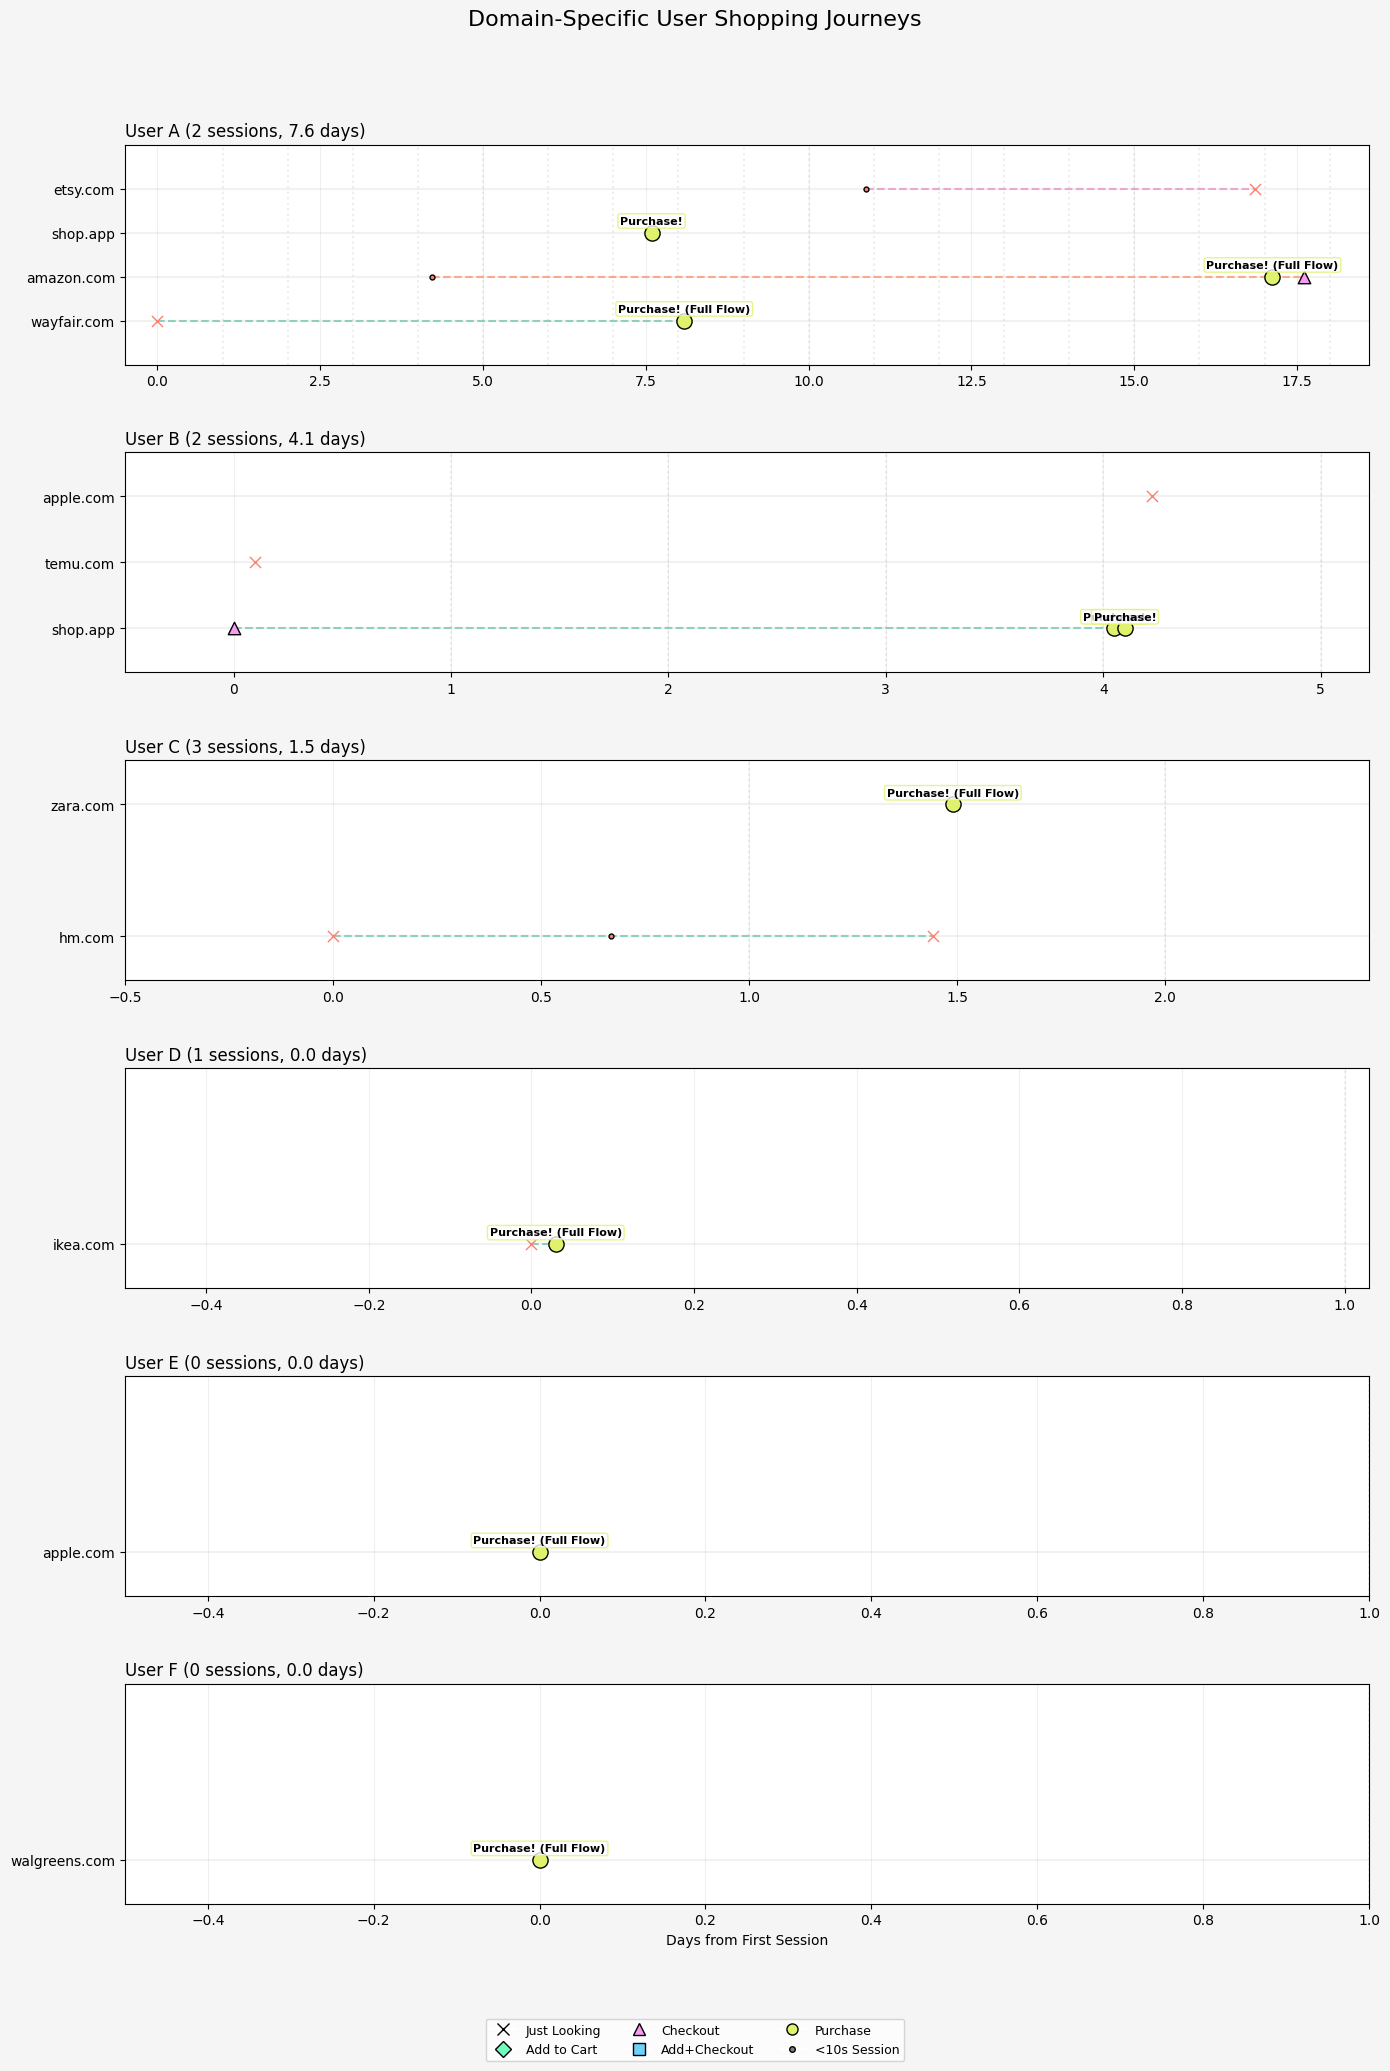

In [47]:
# Create a visualization with domain-specific user journeys
def plot_domain_specific_user_journeys(user_timelines, max_users=6):
    # Limit to max_users for readability
    if len(user_timelines) > max_users:
        user_timelines = user_timelines[:max_users]
    
    num_users = len(user_timelines)
    
    # Create subplots - one for each user
    fig, axes = plt.subplots(num_users, 1, figsize=(14, num_users * 3.5), facecolor=facecolor)
    
    # Handle the case where there's only one user
    if num_users == 1:
        axes = [axes]
    
    for i, (user_timeline, ax) in enumerate(zip(user_timelines, axes)):
        # Extract data for this user
        user_id = user_timeline['user_id']
        domains = user_timeline['all_domains']
        domain_timelines = user_timeline['domain_timelines']
        
        # Calculate all time points for proper scaling
        all_times = []
        for domain in domains:
            timeline_data = domain_timelines[domain]
            all_times.extend([session['time_days'] for session in timeline_data])
        
        if not all_times:  # Skip if no data
            continue
            
        # Calculate vertical spacing for each domain
        num_domains = len(domains)
        y_positions = np.linspace(0.2, 0.8, num_domains)
        domain_y_map = {domain: y_pos for domain, y_pos in zip(domains, y_positions)}
        
        # First pass: plot connecting lines for each domain
        for j, domain in enumerate(domains):
            timeline_data = domain_timelines[domain]
            if not timeline_data:  # Skip if no data for this domain
                continue
                
            y_pos = domain_y_map[domain]
            times = [session['time_days'] for session in timeline_data]
            
            # Plot domain-specific connecting line
            ax.plot(times, [y_pos] * len(times), '--', 
                   color=domain_colors[j % len(domain_colors)], 
                   alpha=0.7, zorder=1, linewidth=1.5, 
                   label=domain)
        
        # Second pass: plot individual sessions as markers
        for j, domain in enumerate(domains):
            timeline_data = domain_timelines[domain]
            if not timeline_data:  # Skip if no data for this domain
                continue
                
            y_pos = domain_y_map[domain]
            
            # Plot each session for this domain
            for session in timeline_data:
                # Determine the marker
                if session['has_purchase']:
                    marker = 'o'  # Purchase
                    size = 120
                    zorder = 10
                elif session['is_very_short']:
                    marker = '.'  # Very short
                    size = 50
                    zorder = 5
                else:
                    marker = session['marker']
                    size = session['size'] * 0.8
                    zorder = session['zorder']
                
                # Plot the marker
                ax.scatter(
                    session['time_days'], 
                    y_pos,
                    color=session['color'],
                    s=size,
                    marker=marker,
                    zorder=zorder,
                    edgecolors='black',
                    linewidth=1
                )
                
                # Add short label for purchase sessions
                if session['has_purchase']:
                    purchase_label = "Purchase!"
                    # Check if this was a complete flow (add to cart + checkout + purchase)
                    if 'Complete Flow' in session['flow_category']:
                        purchase_label = "Purchase! (Full Flow)"
                    
                    ax.text(
                        session['time_days'],
                        y_pos + 0.03,
                        purchase_label,
                        rotation=0,
                        ha='center',
                        va='bottom',
                        fontsize=8,
                        fontweight='bold',
                        color='black',
                        bbox=dict(facecolor='white', alpha=0.8, edgecolor=colors[4], boxstyle='round,pad=0.2'),
                        zorder=zorder + 1
                    )
        
        # Add day markers on the x-axis
        max_time = max(all_times) if all_times else 10
        day_markers = list(range(0, int(max_time) + 2))
        for day in day_markers:
            if day > 0:  # Skip day 0
                ax.axvline(x=day, color='lightgray', linestyle=':', alpha=0.4, zorder=0)
        
        # Add grid lines for each domain's position
        for y_pos in y_positions:
            ax.axhline(y=y_pos, color='lightgray', linestyle='-', alpha=0.3, zorder=0)
        
        # Set plot title and labels
        ax.set_title(f'User {chr(65+i)} ({user_timeline["sessions_before_purchase"]} sessions, {user_timeline["original_days_to_purchase"]:.1f} days)', 
                   fontsize=12, loc='left')
        
        # Set yticks to show domain names
        ax.set_yticks(y_positions)
        ax.set_yticklabels([f"{domain}" for domain in domains])
        
        # Set axis limits
        ax.set_xlim(left=-0.5, right=max_time + 1)
        ax.set_ylim(0, 1)
        
        # Add grid for better readability
        ax.grid(True, axis='x', alpha=0.2)
        
        # Only add x-axis label to the bottom plot
        if i == num_users - 1:
            ax.set_xlabel('Days from First Session', fontsize=10)
    
    # Add a legend for session types at the bottom of the figure
    legend_elements = [
        plt.Line2D([0], [0], marker='x', color='w', markerfacecolor=colors[0], markersize=8, label='Just Looking', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=colors[2], markersize=8, label='Add to Cart', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='^', color='w', markerfacecolor=colors[1], markersize=8, label='Checkout', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[3], markersize=8, label='Add+Checkout', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[4], markersize=8, label='Purchase', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='gray', markersize=8, label='<10s Session', markeredgecolor='black')
    ]
    
    # Place legend at the bottom center with 3 columns for compactness
    fig.legend(handles=legend_elements, loc='lower center', ncol=3, frameon=True, 
              bbox_to_anchor=(0.5, 0), fontsize=9)
    
    # Add overall title
    plt.suptitle('Domain-Specific User Shopping Journeys', fontsize=16, y=0.98)
    
    # Adjust layout to make room for the legend and ensure proper spacing
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.subplots_adjust(hspace=0.4)
    
    plt.show()

# Create the domain-specific visualization
plot_domain_specific_user_journeys(user_domain_timelines)

## Unified Domain-Specific Journey View

Now let's create a single timeline view showing multiple users and their domain-specific journeys.

/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_35677/2433917162.py:103: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


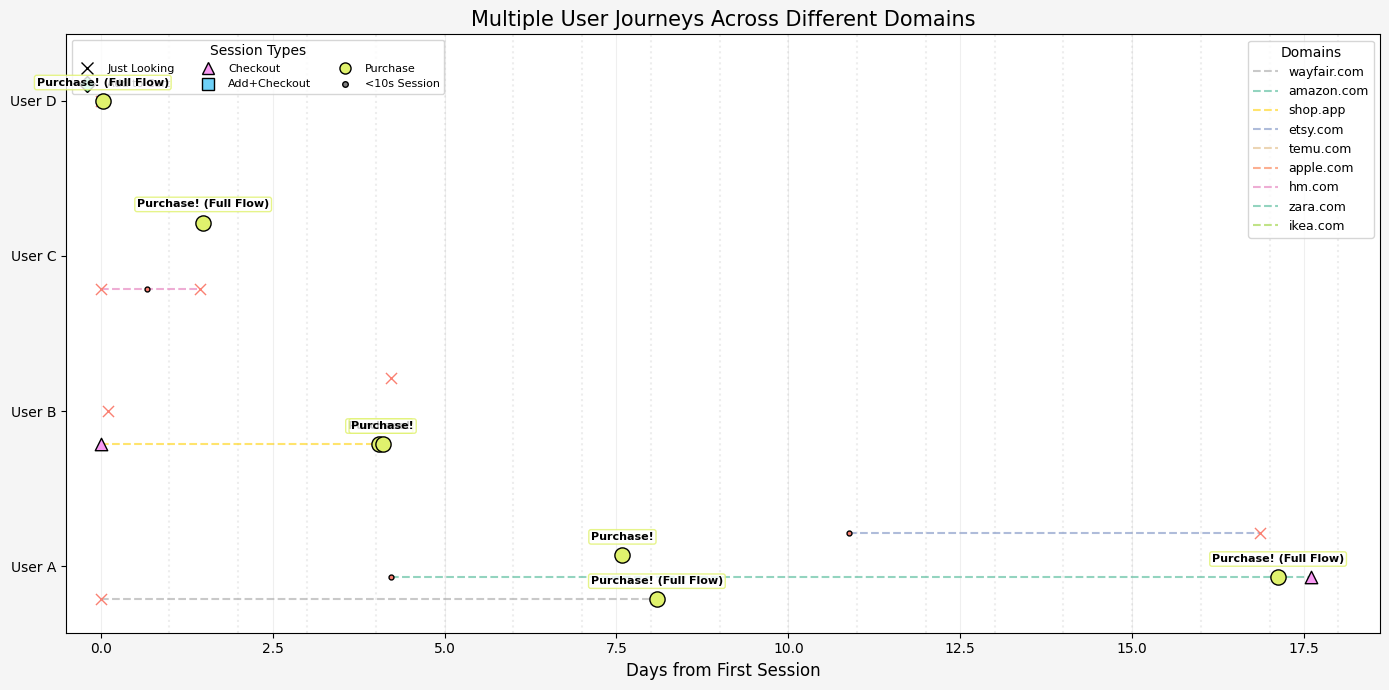

In [46]:
# Create a unified visualization of domain-specific user journeys
def plot_unified_domain_specific_journeys(user_timelines, max_users=4):
    # Limit to max_users for readability
    if len(user_timelines) > max_users:
        user_timelines = user_timelines[:max_users]
    
    num_users = len(user_timelines)
    
    # Set up the plot
    plt.figure(figsize=(14, 7), facecolor=facecolor)
    
    # Track all domains across all users for the legend
    all_domains = set()
    for user_timeline in user_timelines:
        all_domains.update(user_timeline['all_domains'])
    
    # Sort domains for consistent colors
    all_domains = sorted(list(all_domains))
    domain_color_map = {domain: domain_colors[i % len(domain_colors)] for i, domain in enumerate(all_domains)}
    
    # Calculate vertical spacing for each user
    user_positions = np.linspace(0.15, 0.85, num_users)
    domain_offset = 0.05  # Vertical offset between domain lines for the same user
    
    # Calculate all time points for proper scaling
    all_times = []
    
    # First pass: plot the domain lines for each user
    domain_lines = []  # Track domain lines for the legend
    for i, user_timeline in enumerate(user_timelines):
        user_domains = user_timeline['all_domains']
        user_y_base = user_positions[i]
        
        # Calculate offsets for this user's domains
        num_domains = len(user_domains)
        if num_domains > 1:
            domain_offsets = np.linspace(-domain_offset, domain_offset, num_domains)
        else:
            domain_offsets = [0]  # No offset needed for a single domain
        
        domain_y_map = {domain: user_y_base + offset for domain, offset in zip(user_domains, domain_offsets)}
        
        # Plot each domain line
        for j, domain in enumerate(user_domains):
            timeline_data = user_timeline['domain_timelines'][domain]
            if not timeline_data:  # Skip if no data for this domain
                continue
                
            times = [session['time_days'] for session in timeline_data]
            all_times.extend(times)
            y_pos = domain_y_map[domain]
            
            # Use consistent color for the same domain across users
            domain_color = domain_color_map[domain]
            
            # Plot the domain line
            line, = plt.plot(times, [y_pos] * len(times), '--', 
                           color=domain_color, 
                           alpha=0.7, zorder=1, linewidth=1.5)
            
            # Add to our domain lines collection for legend if this is the first user with this domain
            if domain not in [d[0] for d in domain_lines]:
                domain_lines.append((domain, line))
    
    # Second pass: plot the individual sessions
    for i, user_timeline in enumerate(user_timelines):
        user_domains = user_timeline['all_domains']
        user_y_base = user_positions[i]
        
        # Re-calculate domain offsets to match first pass
        num_domains = len(user_domains)
        if num_domains > 1:
            domain_offsets = np.linspace(-domain_offset, domain_offset, num_domains)
        else:
            domain_offsets = [0]
        
        domain_y_map = {domain: user_y_base + offset for domain, offset in zip(user_domains, domain_offsets)}
        
        # Plot each session for each domain
        for domain in user_domains:
            timeline_data = user_timeline['domain_timelines'][domain]
            if not timeline_data:  # Skip if no data
                continue
                
            y_pos = domain_y_map[domain]
            
            for session in timeline_data:
                # Determine the marker
                if session['has_purchase']:
                    marker = 'o'  # Purchase
                    size = 120
                    zorder = 10
                elif session['is_very_short']:
                    marker = '.'  # Very short
                    size = 50
                    zorder = 5
                else:
                    marker = session['marker']
                    size = session['size'] * 0.8
                    zorder = session['zorder']
                
                # Plot the marker
                plt.scatter(
                    session['time_days'], 
                    y_pos,
                    color=session['color'],
                    s=size,
                    marker=marker,
                    zorder=zorder,
                    edgecolors='black',
                    linewidth=1
                )
                
                # Add short label for purchase sessions
                if session['has_purchase']:
                    purchase_label = "Purchase!"
                    # Check if this was a complete flow (add to cart + checkout + purchase)
                    if 'Complete Flow' in session['flow_category']:
                        purchase_label = "Purchase! (Full Flow)"
                    
                    plt.text(
                        session['time_days'],
                        y_pos + 0.02,
                        purchase_label,
                        rotation=0,
                        ha='center',
                        va='bottom',
                        fontsize=8,
                        fontweight='bold',
                        color='black',
                        bbox=dict(facecolor='white', alpha=0.8, edgecolor=colors[4], boxstyle='round,pad=0.2'),
                        zorder=zorder + 1
                    )
    
    # Add day markers on the x-axis
    max_time = max(all_times) if all_times else 10
    day_markers = list(range(0, int(max_time) + 2))
    for day in day_markers:
        if day > 0:  # Skip day 0
            plt.axvline(x=day, color='lightgray', linestyle=':', alpha=0.4, zorder=0)
    
    # Add user labels on the y-axis
    plt.yticks(user_positions, [f"User {chr(65+i)}" for i in range(num_users)])
    
    # Add grid for better readability
    plt.grid(True, axis='x', alpha=0.2)
    
    # Set axis limits and labels
    plt.xlim(left=-0.5, right=max_time + 1)
    plt.ylim(0.05, 0.95)
    plt.xlabel('Days from First Session', fontsize=12)
    
    # Create two legends: one for domains and one for session types
    # Domain legend (place on the right side)
    domain_legend_elements = [line for _, line in domain_lines]
    domain_legend_labels = [domain for domain, _ in domain_lines]
    domain_legend = plt.legend(domain_legend_elements, domain_legend_labels, 
                              loc='upper right', title="Domains", frameon=True, fontsize=9)
    plt.gca().add_artist(domain_legend)  # Add the first legend
    
    # Session type legend (place at the bottom)
    session_legend_elements = [
        plt.Line2D([0], [0], marker='x', color='w', markerfacecolor=colors[0], markersize=8, label='Just Looking', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=colors[2], markersize=8, label='Add to Cart', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='^', color='w', markerfacecolor=colors[1], markersize=8, label='Checkout', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[3], markersize=8, label='Add+Checkout', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[4], markersize=8, label='Purchase', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='gray', markersize=8, label='<10s Session', markeredgecolor='black')
    ]
    
    plt.legend(handles=session_legend_elements, loc='upper left', ncol=3, frameon=True, 
              title="Session Types", fontsize=8)
    
    plt.title('Multiple User Journeys Across Different Domains', fontsize=15)
    plt.tight_layout()
    plt.show()

# Create the unified domain-specific visualization
plot_unified_domain_specific_journeys(user_domain_timelines)

## Analysis of Cross-Domain User Journeys

Let's analyze patterns in how users navigate across domains before making purchases:

In [40]:
# Analyze cross-domain shopping patterns
cross_domain_data = []
for user_timeline in user_domain_timelines:
    user_id = user_timeline['user_id']
    domains = user_timeline['all_domains']
    domain_timelines = user_timeline['domain_timelines']
    
    # Count sessions per domain
    domain_sessions = {domain: len(timeline) for domain, timeline in domain_timelines.items()}
    
    # Count purchase sessions per domain
    purchase_sessions = {domain: sum(1 for session in timeline if session['has_purchase']) 
                         for domain, timeline in domain_timelines.items()}
    
    # Find domain with first activity
    first_domain = None
    earliest_time = float('inf')
    for domain, timeline in domain_timelines.items():
        if timeline and timeline[0]['time_days'] < earliest_time:
            earliest_time = timeline[0]['time_days']
            first_domain = domain
    
    # Find domain with last purchase
    purchase_domain = None
    for domain, timeline in domain_timelines.items():
        purchase_sessions = [s for s in timeline if s['has_purchase']]
        if purchase_sessions:
            purchase_domain = domain
            break
    
    cross_domain_data.append({
        'user_id': user_id,
        'domains_visited': list(domains),
        'num_domains': len(domains),
        'domain_sessions': domain_sessions,
        'purchase_sessions': purchase_sessions,
        'first_domain': first_domain,
        'purchase_domain': purchase_domain,
        'same_first_and_purchase': first_domain == purchase_domain
    })

cross_domain_df = pd.DataFrame(cross_domain_data)

# Print statistics
print(f"Average number of domains visited: {cross_domain_df['num_domains'].mean():.2f}")
print(f"Users who purchased on the same domain they first visited: {cross_domain_df['same_first_and_purchase'].sum()} out of {len(cross_domain_df)}")

# Most common first domains
print("\nMost common first domains:")
print(cross_domain_df['first_domain'].value_counts())

# Most common purchase domains
print("\nMost common purchase domains:")
print(cross_domain_df['purchase_domain'].value_counts())

Average number of domains visited: 2.00
Users who purchased on the same domain they first visited: 5 out of 6

Most common first domains:
first_domain
wayfair.com      1
shop.app         1
hm.com           1
ikea.com         1
apple.com        1
walgreens.com    1
Name: count, dtype: int64

Most common purchase domains:
purchase_domain
wayfair.com      1
shop.app         1
zara.com         1
ikea.com         1
apple.com        1
walgreens.com    1
Name: count, dtype: int64
